# Q. #4

In [30]:
# Import all the functions used in part 1
from era_okid_tools import *
prob = "4-3"

In [31]:
# Set seed for consistent results
rng = np.random.default_rng(seed = 100)

dts = (0.125, 0.05, 0.025) # Simulation timestep duration


Note that we have set $l_0 = 45$, $\alpha = 10$, and $\beta = 5$ for this simulation.
We choose frequencies of $\{5, 10, 20\}$ Hz to determine the effect of
data acquisition frequency on the results of the system identification.

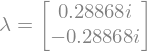

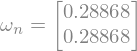

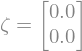

Rank of H(0): 2
Rank of H(1): 2
RMS Error of sim. for system found via OKID for train data, dt = 0.125: [1.56612485e-14 4.44505843e-15]
RMS Error of sim. for system found via OKID for test data, dt = 0.125, case 0: [8.99961167e-14 2.81005323e-14]
RMS Error of sim. for system found via OKID for test data, dt = 0.125, case 1: [1.07201932e-12 2.87191199e-13]
RMS Error of sim. for system found via OKID for test data, dt = 0.125, case 2: [5.40855464e-14 1.65103998e-14]
Rank of H(0): 5
Rank of H(1): 5
RMS Error of sim. for system found via OKID for train data, dt = 0.05: [1.23222661e-12 2.02281735e-13]
RMS Error of sim. for system found via OKID for test data, dt = 0.05, case 0: [4.80797046e-12 1.25404986e-12]
RMS Error of sim. for system found via OKID for test data, dt = 0.05, case 1: [2.87094076e-11 9.59494759e-12]
RMS Error of sim. for system found via OKID for test data, dt = 0.05, case 2: [1.06582358e-12 3.21906996e-13]
Rank of H(0): 2
Rank of H(1): 2
RMS Error of sim. for system found

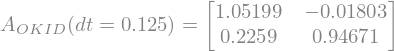

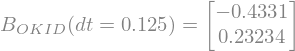

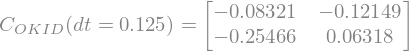

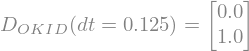

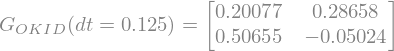

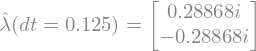

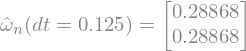

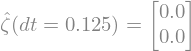

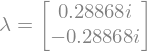

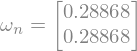

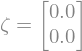

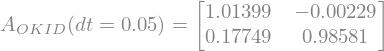

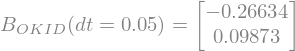

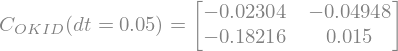

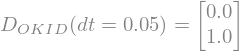

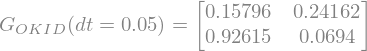

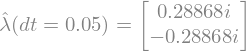

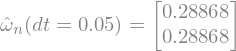

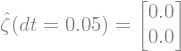

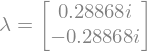

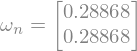

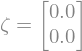

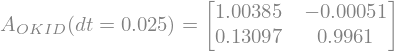

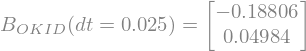

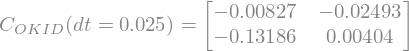

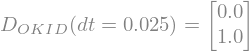

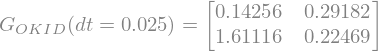

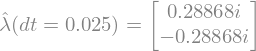

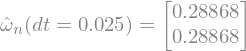

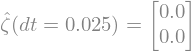

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

In [32]:
for b in range(len(dts)):
    # Simulation dimensions
    cases = 3 # Number of cases
    n = 2 # Number of states
    r = 1 # Number of inputs
    m = 2 # Number of measurements
    t_max = 50 # Total simulation time
    nt = int(t_max/dts[b]) # Number of simulation timesteps
    
    # Simulation time
    train_cutoff = int(20/dts[b]) + 1
    t_sim = np.linspace(0, t_max, nt + 1)
    t_train = t_sim[:train_cutoff]
    t_test = t_sim
    nt_train = train_cutoff
    nt_test = nt
    
    # Problem parameters
    theta_0 = 0.5 # Angular velocity
    k = 10 # Spring stiffness
    mass = 1 # Point mass
    
    # State space model
    A_c = np.array([[0, 1], [theta_0**2 - k/mass, 0]])
    B_c = np.array([[0], [1]])
    C = np.eye(2)
    D = np.array([[0], [1]])
    A, B = c2d(A_c, B_c, dts[b])
    eig_A = spla.eig(A_c)[0] # Eigenvalues of true system
    etch(f"\lambda", eig_A)
    etch(f"\omega_{{n}}", np.abs(eig_A))
    etch(f"\zeta", -np.cos(np.angle(eig_A)))
    
    # True simulation values
    X_0_sim = np.zeros([n, 1]) # Zero initial condition
    U_sim = np.zeros([cases, r, nt]) # True input vectors
    U_sim[0] = rng.normal(0, 0.1, [r, nt]) # True input for case 1
    U_sim[1] = spsg.square(2*np.pi*5*t_sim[:-1]) # True input for case 2
    U_sim[2] = np.cos(2*np.pi*2*t_sim[:-1]) # True input for case 3
    X_sim = np.zeros([cases, n, nt + 1]) # True state vectors
    Z_sim = np.zeros([cases, m, nt]) # True observation vectors
    W_sim = np.zeros([cases, m, nt]) # Measurement noise vectors
    
    # Separation into train and test data
    U_train = U_sim[0, :r, :train_cutoff] # Train input vector
    U_test = U_sim # Test input vectors
    X_train = np.zeros([n, nt_train]) # Train state vector
    X_test = np.zeros([cases, n, nt_test + 1]) # Test state vectors
    Z_train = np.zeros([m, nt_train]) # Train observation vector
    Z_test = np.zeros([cases, m, nt_test]) # Test observation vectors

    # OKID logistics
    order = 45 # Order of OKID algorithm, number of Markov parameters to identify after the zeroeth
    alpha, beta = 10, 5 # Number of block rows and columns in Hankel matrices
    n_era = 2 # Number of proposed states
    X_0_okid = np.zeros([n_era, 1]) # Zero initial condition
    
    # OKID state vector, drawn from state space model derived from OKID/ERA
    X_okid_train = np.zeros([n_era, nt_train + 1])
    X_okid_test = np.zeros([cases, n_era, nt_test + 1])
    # OKID observations, drawn from state space model derived from OKID/ERA
    Z_okid_train = np.zeros([n_era, nt_train])
    Z_okid_test = np.zeros([cases, n_era, nt_test])
    # Singular values of the Hankel matrix constructed through OKID Markov parameters
    S_okid = np.zeros([min(order*m, beta*r)])
    eig_A_okid = np.zeros([n_era], dtype = complex)
    
    A_okid = np.zeros([n_era, n_era])
    B_okid = np.zeros([n_era, r])
    C_okid = np.zeros([m, n_era])
    D_okid = np.zeros([m, r])
    G_okid = np.zeros([m, m])

    # Simulation
    for i in range(cases):
        X_sim[i], Z_sim[i] = sim_ss(A, B, C, D, X_0 = X_0_sim, U = U_sim[i], nt = nt)
        if i == 0:
            # Split between train and test data for case 1
            X_train, Z_train = \
                X_sim[i, :, :train_cutoff], Z_sim[i, :, :train_cutoff]
            # Identify System Markov parameters and Observer Gain Markov parameters
            Y_okid, Y_og_okid = \
                okid(Z_train, U_train,
                     l_0 = order, alpha = alpha, beta = beta, n = n_era)
            # Identify state space model using System Markov parameters for ERA
            A_okid, B_okid, C_okid, D_okid, S_okid = \
                era(Y_okid, alpha = alpha, beta = beta, n = n_era)
            # Construct observability matrix
            O_p_okid = np.array([C_okid @ np.linalg.matrix_power(A_okid, i)
                                 for i in range(order)])
            # Find observer gain matrix
            G_okid = spla.pinv2(O_p_okid.reshape([order*m, n_era])) @ Y_og_okid.reshape([order*m, m])
            X_okid_train, Z_okid_train = \
                sim_ss(A_okid, B_okid, C_okid, D_okid,
                       X_0 = X_0_okid, U = U_train, nt = nt_train)
            # Display outputs
            etch(f"A_{{OKID}}(dt = {dts[b]})", A_okid)
            etch(f"B_{{OKID}}(dt = {dts[b]})", B_okid)
            etch(f"C_{{OKID}}(dt = {dts[b]})", C_okid)
            etch(f"D_{{OKID}}(dt = {dts[b]})", D_okid)
            etch(f"G_{{OKID}}(dt = {dts[b]})", G_okid)
            # Calculate and display eigenvalues
            eig_A_okid = spla.eig(d2c(A_okid, B_okid, dts[b])[0])[0] # Eigenvalues of identified system
            etch(f"\hat{{\lambda}}(dt = {dts[b]})", eig_A_okid)
            etch(f"\hat{{\omega}}_{{n}}(dt = {dts[b]})", np.abs(eig_A_okid))
            etch(f"\hat{{\zeta}}(dt = {dts[b]})", -np.cos(np.angle(eig_A_okid)))
        X_test[i], Z_test[i] = \
            X_sim[i], Z_sim[i]
        X_okid_test[i], Z_okid_test[i] = \
            sim_ss(A_okid, B_okid, C_okid, D_okid,
                   X_0 = X_0_okid, U = U_test[i], nt = nt_test)

    RMS_train = np.sqrt(np.mean((Z_okid_train - Z_train)**2, axis = 1))
    print(f"RMS Error of sim. for system found via OKID for train data, dt = {dts[b]}: {RMS_train}")
    for i in range(cases):
        RMS_test = np.sqrt(np.mean((Z_okid_test[i] - Z_test[i])**2, axis = 1))
        print(f"RMS Error of sim. for system found via OKID for test data, dt = {dts[b]}, case {i}: {RMS_test}")
    
    # Eigenvalue plots
    fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"[{prob}] Eigenvalues", fontweight = "bold")
    
    ax.plot(np.real(eig_A), np.imag(eig_A),
             "o", mfc = "None")
    ax.plot(np.real(eig_A_okid), np.imag(eig_A_okid),
            "o", mfc = "None")
    
    fig.legend(labels = ("True", *[f"OKID ($dt$ = {q})" for q in dts]),
               bbox_to_anchor = (1, 0.5), loc = 6)
    fig.savefig(figs_dir / f"midterm_{prob}_eigval_dt{b}.pdf",
                bbox_inches = "tight")
    
    # Singular Value plots
    fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
    fig.suptitle(f"[{prob}] Singular Values", fontweight = "bold")

    ax.plot(np.linspace(1, len(S_okid), len(S_okid)), S_okid,
            "o", mfc = "None")
    plt.setp(ax, xlabel = f"Singular Value", ylabel = f"Value",
             xticks = np.arange(1, S_okid.shape[-1] + 1))
    
    fig.legend(labels = [f"OKID ($dt$ = {q})" for q in dts],
               bbox_to_anchor = (1, 0.5), loc = 6)
    fig.savefig(figs_dir / f"midterm_{prob}_singval_dt{b}.pdf",
                bbox_inches = "tight")
    
    # Observation plots
    ms = 0.5
    for i in range(cases):
        # Raw observations
        raw_fig, axs = plt.subplots(m, 1,
                                    sharex = "col", constrained_layout = True) # type:figure.Figure
        raw_fig.suptitle(f"[{prob}] Observation Responses (Case {i + 1})\n$dt$ = {dts[b]}",
                         fontweight = "bold")
        if i == 0:
            for j in range(m):
                axs[j].plot(t_sim[:-1], Z_sim[i, j])
                axs[j].plot(t_train, Z_train[j],
                            "o", ms = ms, mfc = "None")
                axs[j].plot(t_test[train_cutoff:-1], Z_test[i, j, train_cutoff:],
                            "s", ms = ms, mfc = "None")
                axs[j].plot(t_train, Z_okid_train[j],
                            "o", ms = ms, mfc = "None")
                axs[j].plot(t_test[train_cutoff:-1], Z_okid_test[i, j, train_cutoff:],
                            "D", ms = ms, mfc = "None")
                plt.setp(axs[j], ylabel = f"$z_{j}$",
                         xlim = [0, t_max])
                if j == (m - 1):
                    plt.setp(axs[j], xlabel = f"Time")
            raw_fig.legend(labels = ["True", "Train", "Test",
                                     "OKID\n(Train)", "OKID\n(Test)"],
                           bbox_to_anchor = (1, 0.5), loc = 6)
        else:
            for j in range(m):
                axs[j].plot(t_sim[:-1], Z_sim[i, j])
                axs[j].plot(t_test[:-1], Z_test[i, j],
                            "o", ms = ms, mfc = "None")
                axs[j].plot(t_test[:-1], Z_okid_test[i, j],
                            "s", ms = ms, mfc = "None")
                plt.setp(axs[j], ylabel = f"$z_{j}$",
                         xlim = [0, t_max])
                if j == (m - 1):
                    plt.setp(axs[j], xlabel = f"Time")
            raw_fig.legend(labels = ["True", "Test", "OKID\nTest"],
                           bbox_to_anchor = (1, 0.5), loc = 6)
        raw_fig.savefig(figs_dir / f"midterm_{prob}_obs_case{i + 1}_dt{b}.pdf",
                        bbox_inches = "tight")
    
        # Observation error
        err_fig, axs = plt.subplots(m, 1,
                                    sharex = "col", constrained_layout = True) # type:figure.Figure
        err_fig.suptitle(f"[{prob}] Observation Error (Case {i + 1})\n$dt$ = {dts[b]}",
                         fontweight = "bold")
        if i == 0:
            for j in range(m):
                axs[j].plot(t_train, np.abs(Z_okid_train[j] - Z_train[j]),
                            c = "C1")
                axs[j].plot(t_test[train_cutoff:-1], np.abs(Z_okid_test[i, j, train_cutoff:] - Z_test[i, j, train_cutoff:]),
                            "o", ms = ms, mfc = "None", c = "C0")
                plt.setp(axs[j], ylabel = f"$z_{j}$",
                         xlim = [0, t_max])
                if j == (m - 1):
                    plt.setp(axs[j], xlabel = f"Time")
            err_fig.legend(labels = ["OKID\nTrain", "OKID\nTest"],
                           bbox_to_anchor = (1, 0.5), loc = 6)
        else:
            for j in range(m):
                axs[j].plot(t_test[:-1], np.abs(Z_okid_test[i, j] - Z_test[i, j]),
                            "o", ms = ms, mfc = "None")
                plt.setp(axs[j], ylabel = f"$z_{j}$",
                         xlim = [0, t_max])
                if j == (m - 1):
                    plt.setp(axs[j], xlabel = f"Time")
            err_fig.legend(labels = ["OKID\nTest"],
                           bbox_to_anchor = (1, 0.5), loc = 6)
        err_fig.savefig(figs_dir / f"midterm_{prob}_obs-error_case{i + 1}_dt{b}.pdf",
                        bbox_inches = "tight")

In the absence of noise, regardless of the order selected,
the eigenvalues, natural frequencies, and the system as a whole are
able to be identified essentially perfectly.
The realizations are slightly different numerically,
but as shown visually, the results are essentially the same.

The RMS error for the test cases is essentially zero regardless of Hankel height.

The main impact of the Hankel height is on the singular values.
Although in this case the realization wasn't affected,
increasing $\alpha$ led the singular values to become more disjointed,
allowing us to more easily identify the order of the underlying system.
As seen in the plot above,
the difference between the 1st and 2nd singular values drastically increased
for higher $\alpha$, and the difference
between the 2nd and 3rd singular values slighly increased for higher $\alpha.$

The estimation is flawless regardless of the observer order chosen.
In this case where there is no noise,
we conclude that lowering or highering the Hankel height
did not have any practical negative impact on the
high accuracy of the identification of this simple system.